In [1]:
from pathlib import Path

import pytz
from pandas import (
    concat,
    read_csv,
    to_datetime,
)

from post_processing.dataclass.data_aplose import DataAplose
from post_processing.utils.fpod_utils import csv_folder, cpod2aplose, fpod2aplose, actual_data, meta_cut_aplose, dpm_to_dp10m, dpm_to_dph, dpm_to_dpd,fb_folder, build_range, extract_site, percent_calc, site_percent, year_percent, ym_percent, month_percent, hour_percent
from post_processing.utils.core_utils import json2df,get_season

### Pre-processing



In [2]:
data = csv_folder(r"U:\Cetiroise")
print(data.head())

df_0 = data.dropna()

                                                File  podN          ChunkEnd  \
0  CETIROISEPHASE4POINTC 2023 02 03 FPOD_6669 fil...  6669  07/02/2023 05:34   
1  CETIROISEPHASE4POINTC 2023 02 03 FPOD_6669 fil...  6669  07/02/2023 05:35   
2  CETIROISEPHASE4POINTC 2023 02 03 FPOD_6669 fil...  6669  07/02/2023 05:36   
3  CETIROISEPHASE4POINTC 2023 02 03 FPOD_6669 fil...  6669  07/02/2023 22:40   
4  CETIROISEPHASE4POINTC 2023 02 03 FPOD_6669 fil...  6669  24/02/2023 15:32   

     Minute  DPM  MinsOn      deploy.name  
0  64748494    1       1  Point C_Phase 4  
1  64748495    1       1  Point C_Phase 4  
2  64748496    1       1  Point C_Phase 4  
3  64749520    1       1  Point C_Phase 4  
4  64773572    1       1  Point C_Phase 4  


In [3]:
d_beg_end = actual_data(df_0, col_timestamp="ChunkEnd")

In [5]:
df_1 = df_0[df_0["DPM"] !=0 ]

## APLOSE format

#### *CPOD*

In [ ]:
df_aplose = cpod2aplose(df_1, pytz.utc, "Site D Simone", "Commerson")
print(df_aplose.head())

#### *FPOD*

In [6]:
df_aplose = fpod2aplose(df_1, pytz.utc, "CETIROISE", "Marsouin")
print(df_aplose.head())

     dataset filename  start_time  end_time  start_frequency  end_frequency  \
0  CETIROISE                    0        60                0              0   
1  CETIROISE                    0        60                0              0   
2  CETIROISE                    0        60                0              0   
3  CETIROISE                    0        60                0              0   
4  CETIROISE                    0        60                0              0   

  annotation annotator                start_datetime  \
0   Marsouin      FPOD  2023-02-07T05:34:00.000+0000   
1   Marsouin      FPOD  2023-02-07T05:35:00.000+0000   
2   Marsouin      FPOD  2023-02-07T05:36:00.000+0000   
3   Marsouin      FPOD  2023-02-07T22:40:00.000+0000   
4   Marsouin      FPOD  2023-02-24T15:32:00.000+0000   

                   end_datetime  is_box      deploy.name  
0  2023-02-07T05:35:00.000+0000       0  Point C_Phase 4  
1  2023-02-07T05:36:00.000+0000       0  Point C_Phase 4  
2  2023-02-

## Remove non usable lines

In [7]:
json = Path(r"C:\Users\fouinel\Downloads\deployment_cetiroise.json")
metadatax = json2df(json_path=json)

metadatax["deploy.name"] = (metadatax["site.name"].astype(str) + "_" +
                           metadatax["campaign.name"].astype(str))

cleared = meta_cut_aplose(df_aplose, metadatax)

In [8]:
cleared.to_csv(r"U:\APLOSE_CETIROISE_pos.csv", index=False)

## Load data


In [9]:
yaml_file = Path(r"resource\CPOD-FPOD_yaml.yml")
data_list = DataAplose.from_yaml(file=yaml_file)
print(data_list.df.head())

     dataset  filename  start_time  end_time  start_frequency  end_frequency  \
0  CETIROISE       NaN           0        60                0              0   
1  CETIROISE       NaN           0        60                0              0   
2  CETIROISE       NaN           0        60                0              0   
3  CETIROISE       NaN           0        60                0              0   
4  CETIROISE       NaN           0        60                0              0   

  annotation annotator            start_datetime              end_datetime  \
0   Marsouin      FPOD 2023-02-07 05:34:00+00:00 2023-02-07 05:35:00+00:00   
1   Marsouin      FPOD 2023-02-07 05:35:00+00:00 2023-02-07 05:36:00+00:00   
2   Marsouin      FPOD 2023-02-07 05:36:00+00:00 2023-02-07 05:37:00+00:00   
3   Marsouin      FPOD 2023-02-07 22:40:00+00:00 2023-02-07 22:41:00+00:00   
4   Marsouin      FPOD 2023-02-24 15:32:00+00:00 2023-02-24 15:33:00+00:00   

   is_box      deploy.name  
0       0  Point C_Ph

## Format choice


In [ ]:
dp10 = dpm_to_dp10m(data_list.df, extra_columns=["deploy.name"])

In [10]:
dph = dpm_to_dph(data_list.df, extra_columns=["deploy.name"])

In [ ]:
dpd = dpm_to_dpd(data_list.df, extra_columns=["deploy.name"])

## Add the feeding buzzes

In [11]:
fb_files = Path(r"U:\fb_fpod_cetiroise_c")
fb_all = fb_folder(fb_files, "Marsouin")

fb_all["start_datetime"] = fb_all["start_datetime"].dt.floor("h")
fb = fb_all.groupby("start_datetime")["Foraging"].sum().reset_index()
fb["start_datetime"] = to_datetime(fb["start_datetime"], utc=True)

In [12]:
d_tot = dph.merge(fb, on="start_datetime", how="left")

d_hour = build_range(d_beg_end, "h")

In [13]:
d_fin = d_hour.merge(d_tot, on=["start_datetime", "deploy.name"], how="left")

In [14]:
d_fin[["DPM","Foraging"]] = d_fin[["DPM","Foraging"]].fillna(0)
print(d_hour.head())

       deploy.name            start_datetime
0  Point C_Phase 4 2023-02-07 05:00:00+00:00
1  Point C_Phase 4 2023-02-07 06:00:00+00:00
2  Point C_Phase 4 2023-02-07 07:00:00+00:00
3  Point C_Phase 4 2023-02-07 08:00:00+00:00
4  Point C_Phase 4 2023-02-07 09:00:00+00:00


## Add time columns

In [15]:
d_fin["Year"] = d_fin["start_datetime"].dt.year
d_fin["Month"] = d_fin["start_datetime"].dt.month
d_fin['YM'] = d_fin["Year"].astype(str) + '-' + d_fin["Month"].astype(str)
d_fin['YM'] = to_datetime(d_fin['YM'])
d_fin["Day"] = d_fin["start_datetime"].dt.day
d_fin["Hour"] = d_fin["start_datetime"].dt.hour

d_fin["FBR"] = d_fin["Foraging"] / d_fin["DPM"]
d_fin["DPH"] = (d_fin["DPM"] >0).astype(int)

C:\Users\fouinel\AppData\Local\Temp\ipykernel_4000\4171406010.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d_fin['YM'] = to_datetime(d_fin['YM'])


In [16]:
d_fin["FBR"] = d_fin["FBR"].fillna(0)
d_fin.to_csv(r"U:\Hours_DPM_FBUZZ_SiteCETIROISE.csv", index=False)

## Overview

In [ ]:
ca4 = read_csv(r"U:\Hours_DPM_FBUZZ_SiteCA4.csv")
walde = read_csv(r"U:\Hours_DPM_FBUZZ_SiteWalde.csv")

data_c = concat([ca4, walde])
data_c["start_datetime"] = to_datetime(data_c["start_datetime"])
data_c["start_datetime"] = data_c["start_datetime"].apply(lambda x : x.tz_convert("Europe/Paris"))
data_c["Hour"] = data_c["start_datetime"].dt.hour

In [ ]:
a = read_csv(r"U:\Hours_DPM_FBUZZ_SiteA.csv")
b = read_csv(r"U:\Hours_DPM_FBUZZ_SiteB.csv")
c = read_csv(r"U:\Hours_DPM_FBUZZ_SiteC.csv")
d = read_csv(r"U:\Hours_DPM_FBUZZ_SiteD.csv")

data_k = concat([a, b, c, d])
data_k["start_datetime"] = to_datetime(data_k["start_datetime"])
data_k["start_datetime"] = data_k["start_datetime"].apply(lambda x : x.tz_convert("Indian/Kerguelen"))
data_k["Hour"] = data_k["start_datetime"].dt.hour

In [2]:
ceti = read_csv(r"U:\Hours_DPM_FBUZZ_SiteCETIROISE.csv")

ceti["start_datetime"] = to_datetime(ceti["start_datetime"])
ceti["start_datetime"] = ceti["start_datetime"].apply(lambda x : x.tz_convert("CET")) #TimeZone Central European Time
ceti["Hour"] = ceti["start_datetime"].dt.hour

In [3]:
data = ceti
data = extract_site(data)
y_per = percent_calc(data, "Year")
ym_per = percent_calc(data, "YM")
ym_per["YM"] = to_datetime(ym_per["YM"])
ym_per["Season"] = ym_per["YM"].apply(lambda x: get_season(x)[0])
m_per = percent_calc(data, "Month")
h_per = percent_calc(data, "Hour")
s_per = percent_calc(data)

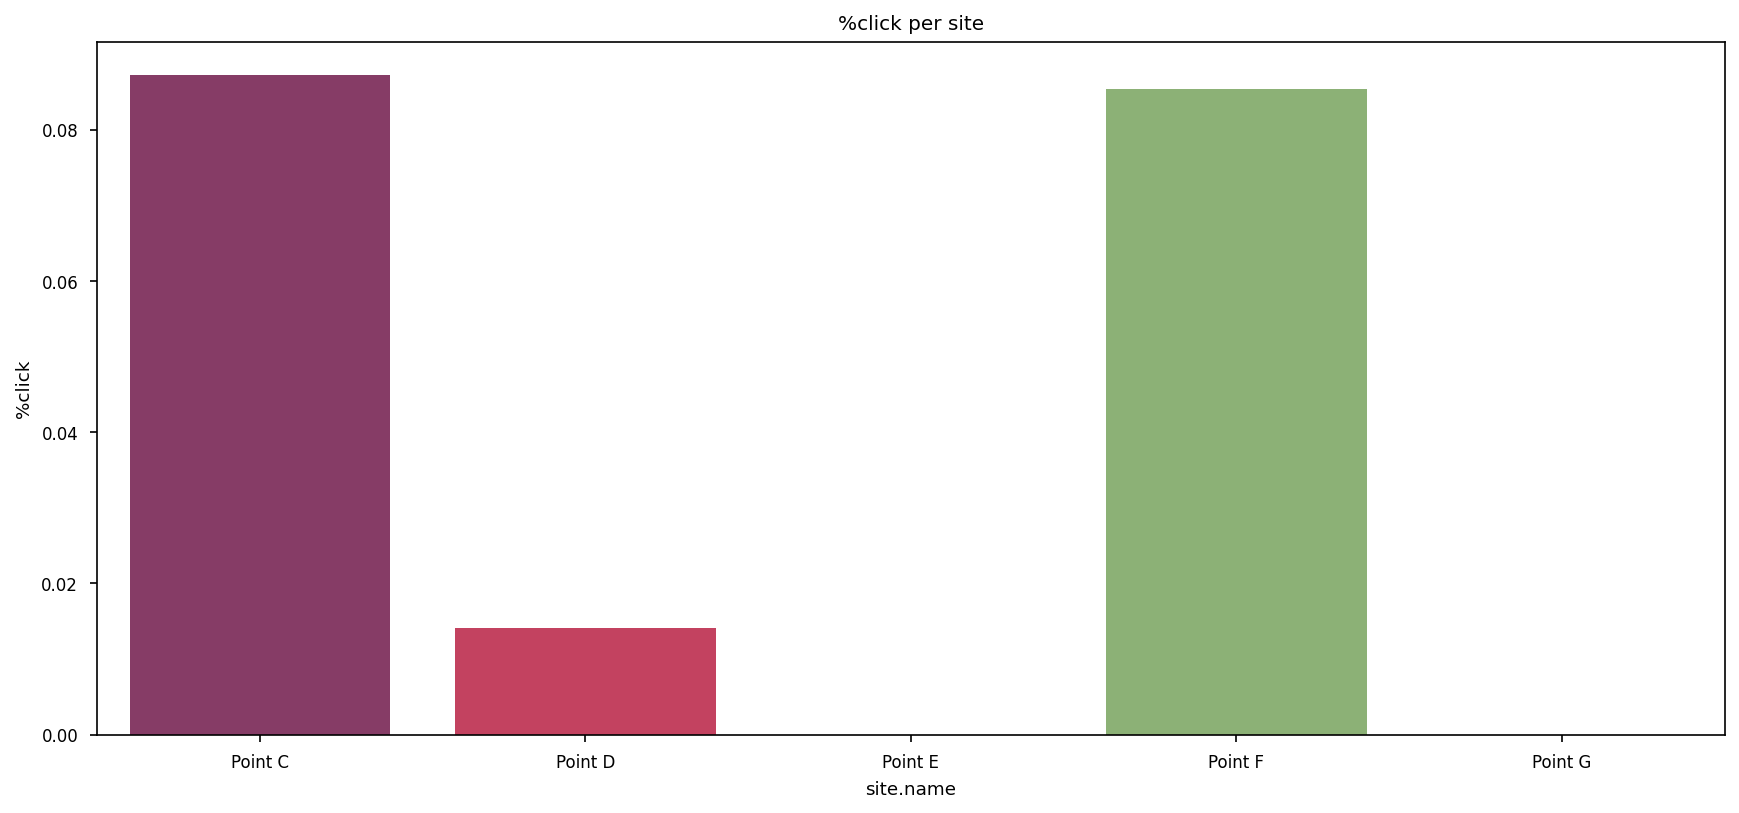

In [4]:
site_percent(s_per, "%click")

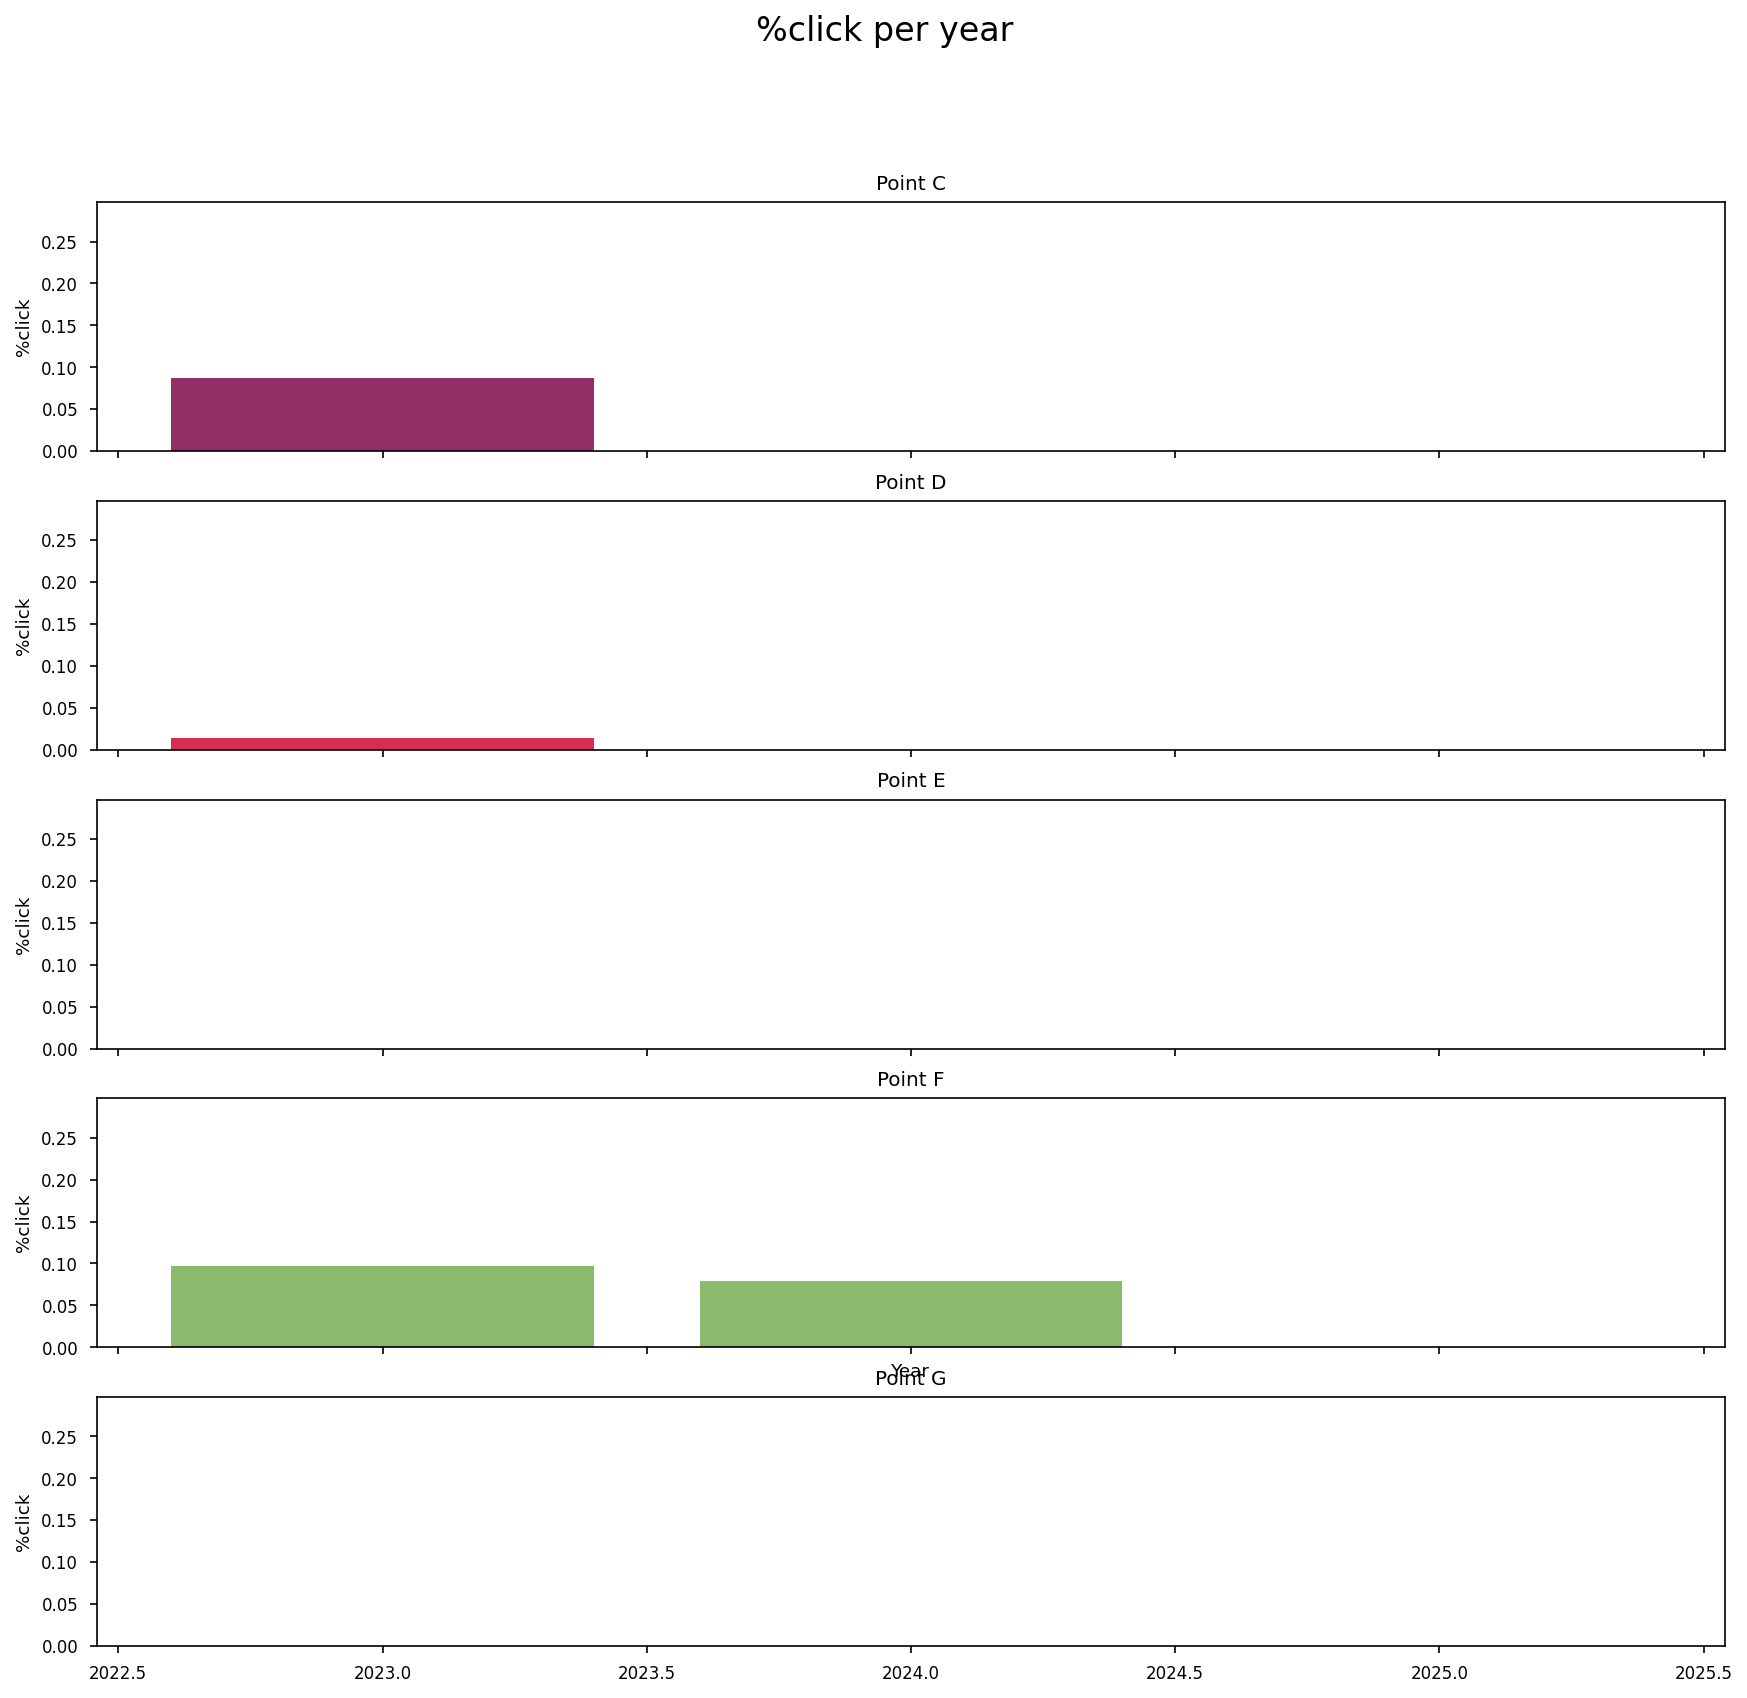

In [5]:
year_percent(y_per, "%click")

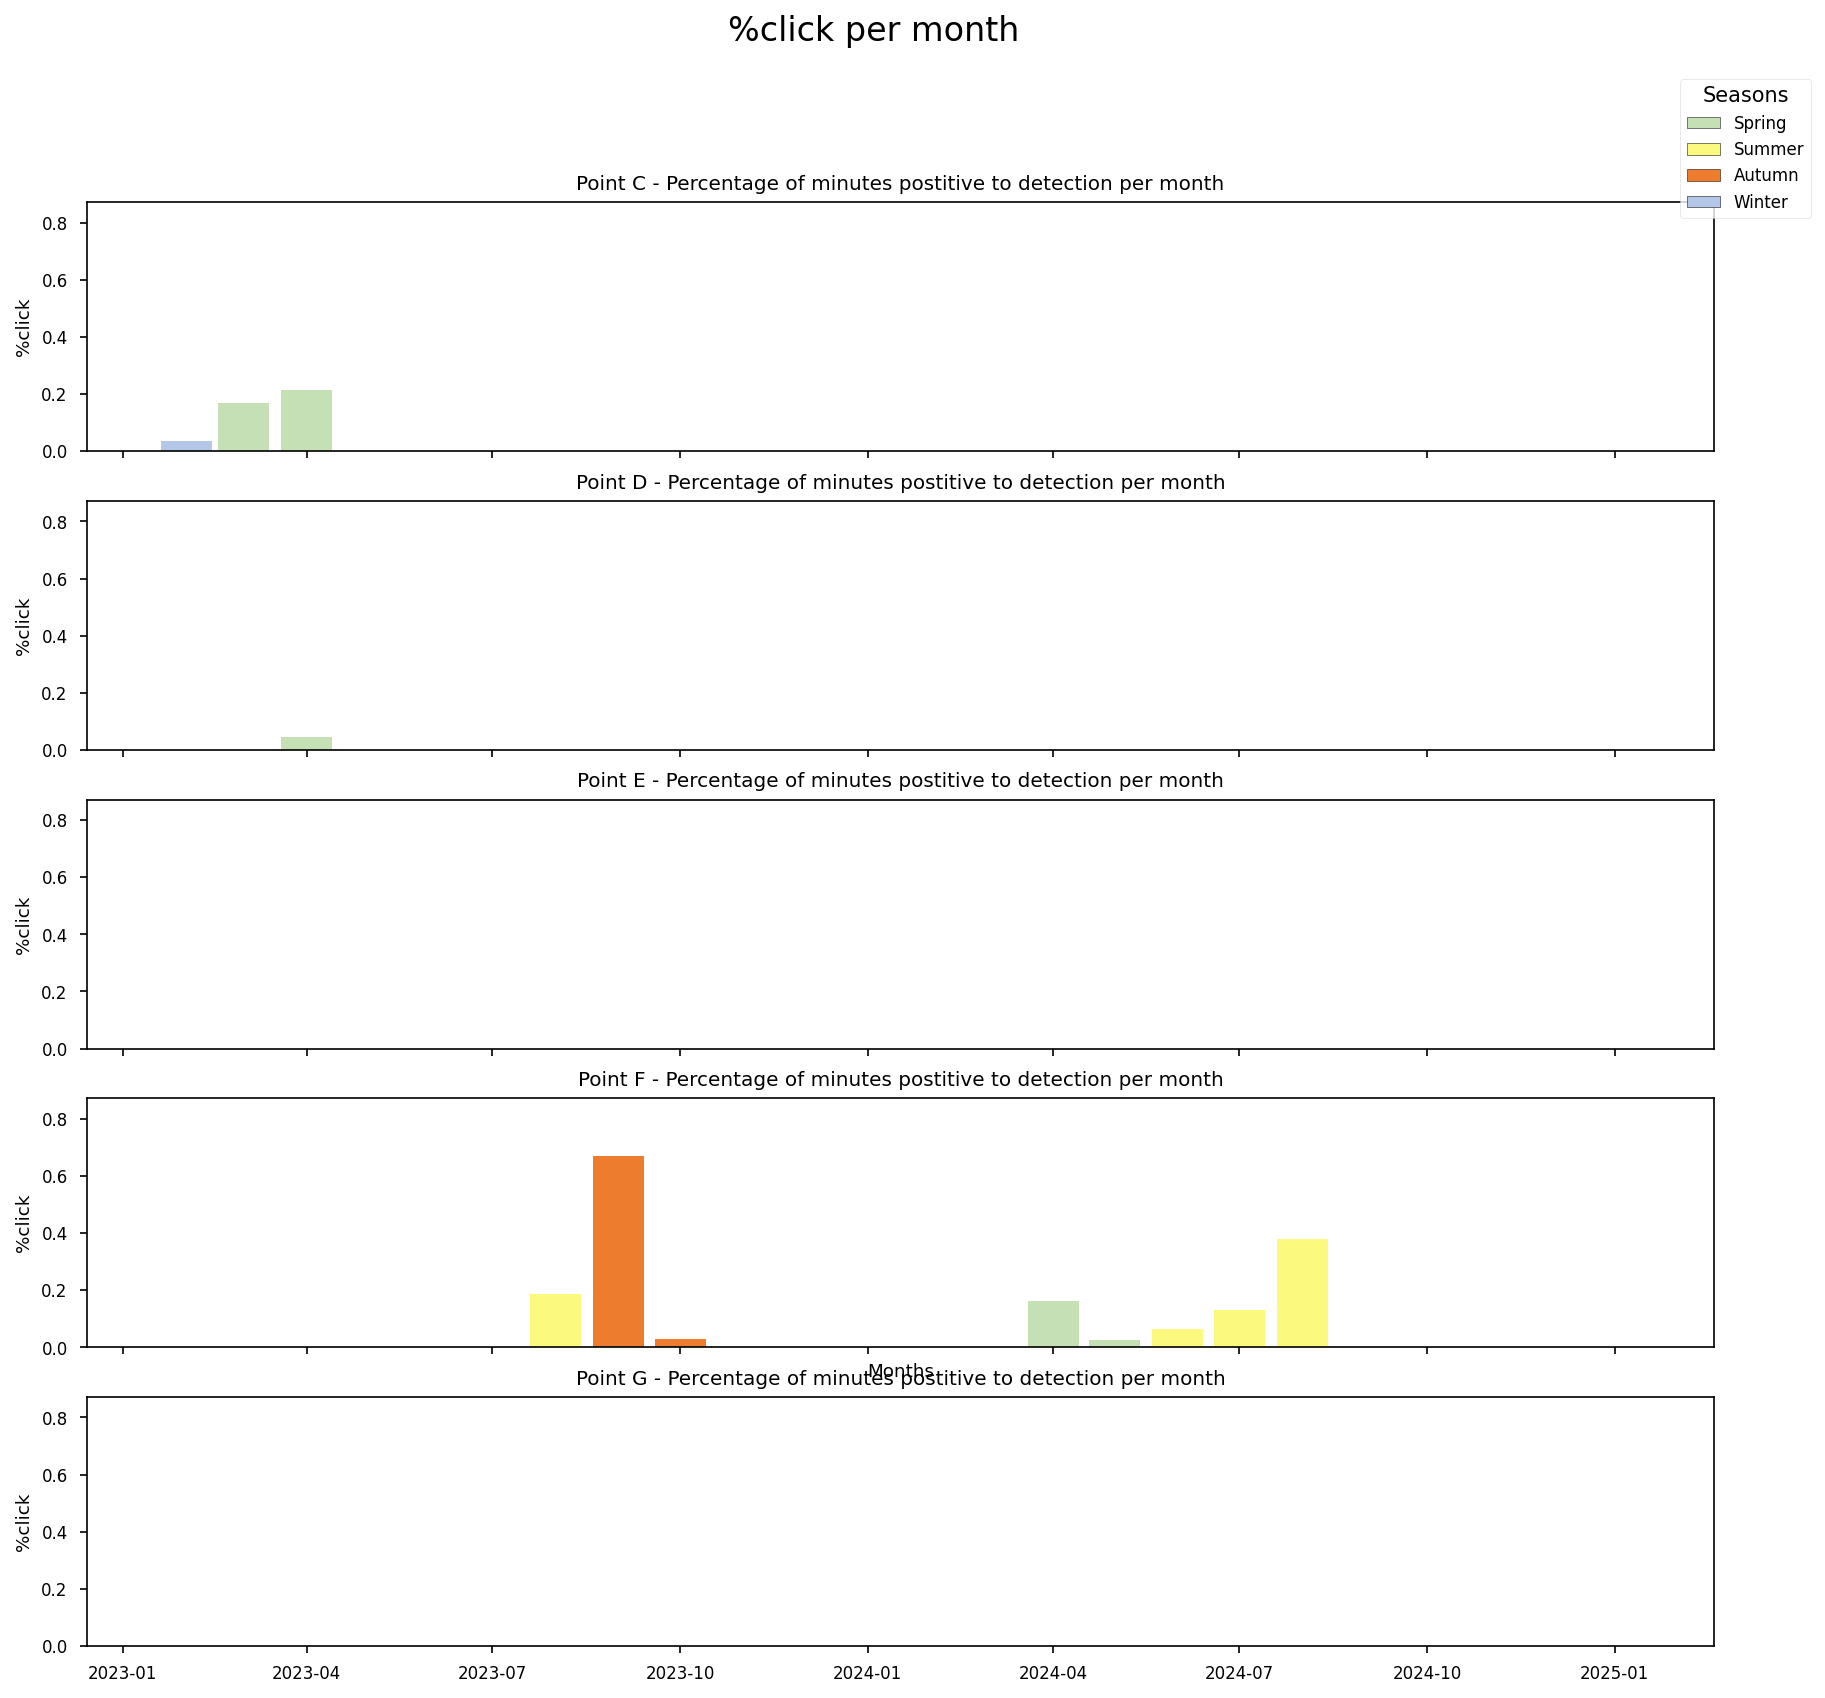

In [6]:
ym_percent(ym_per, "%click")

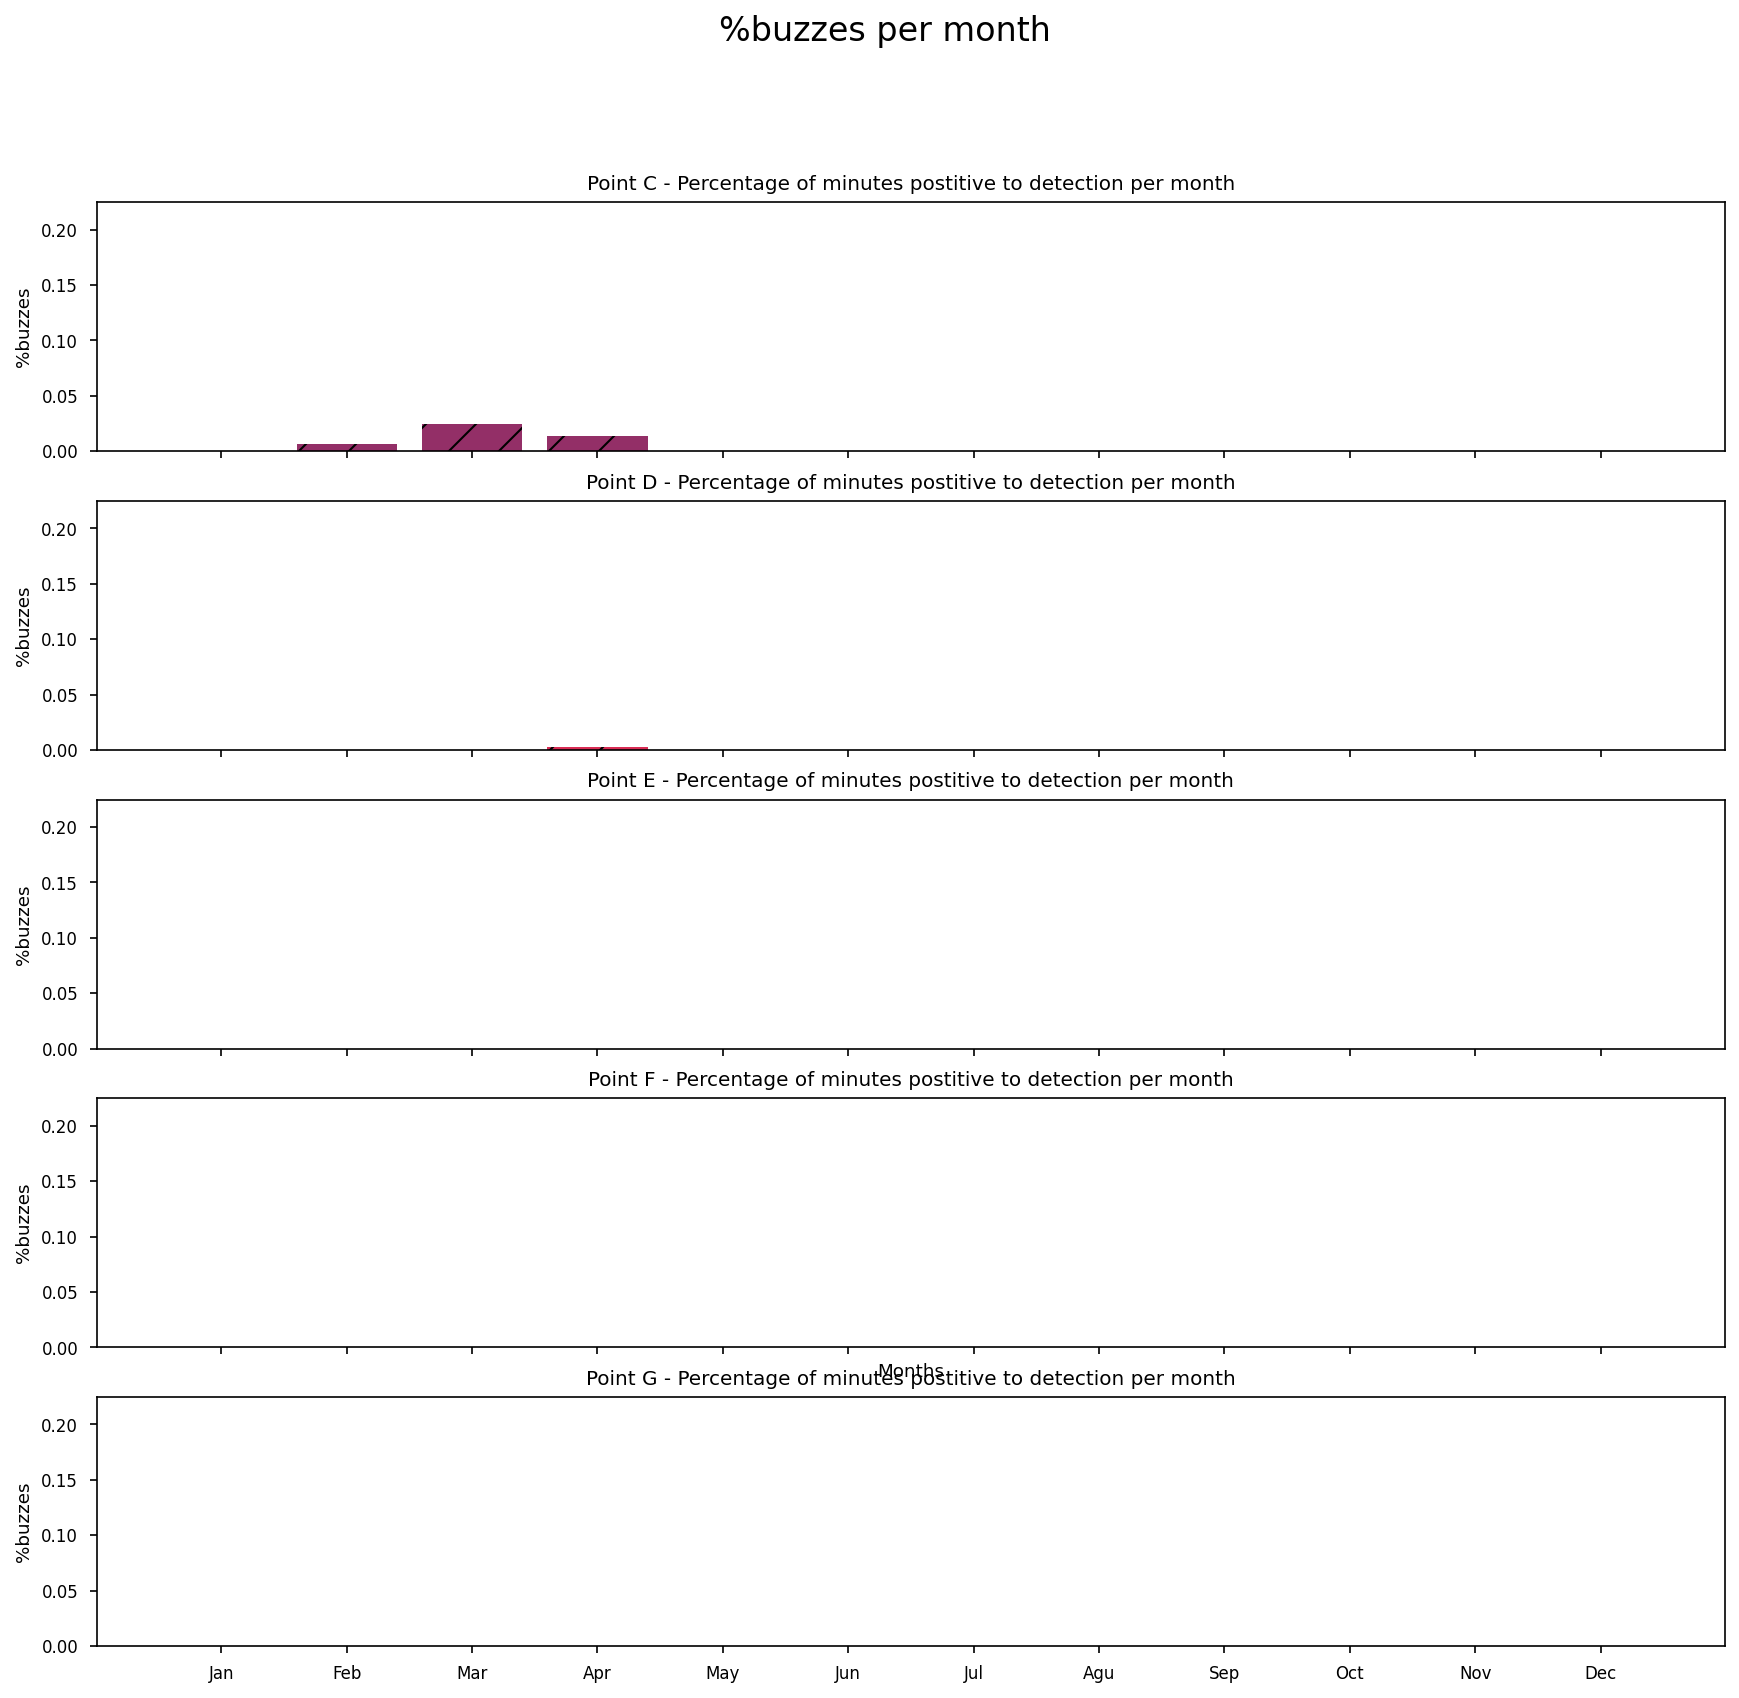

In [7]:
month_percent(m_per, "%buzzes")

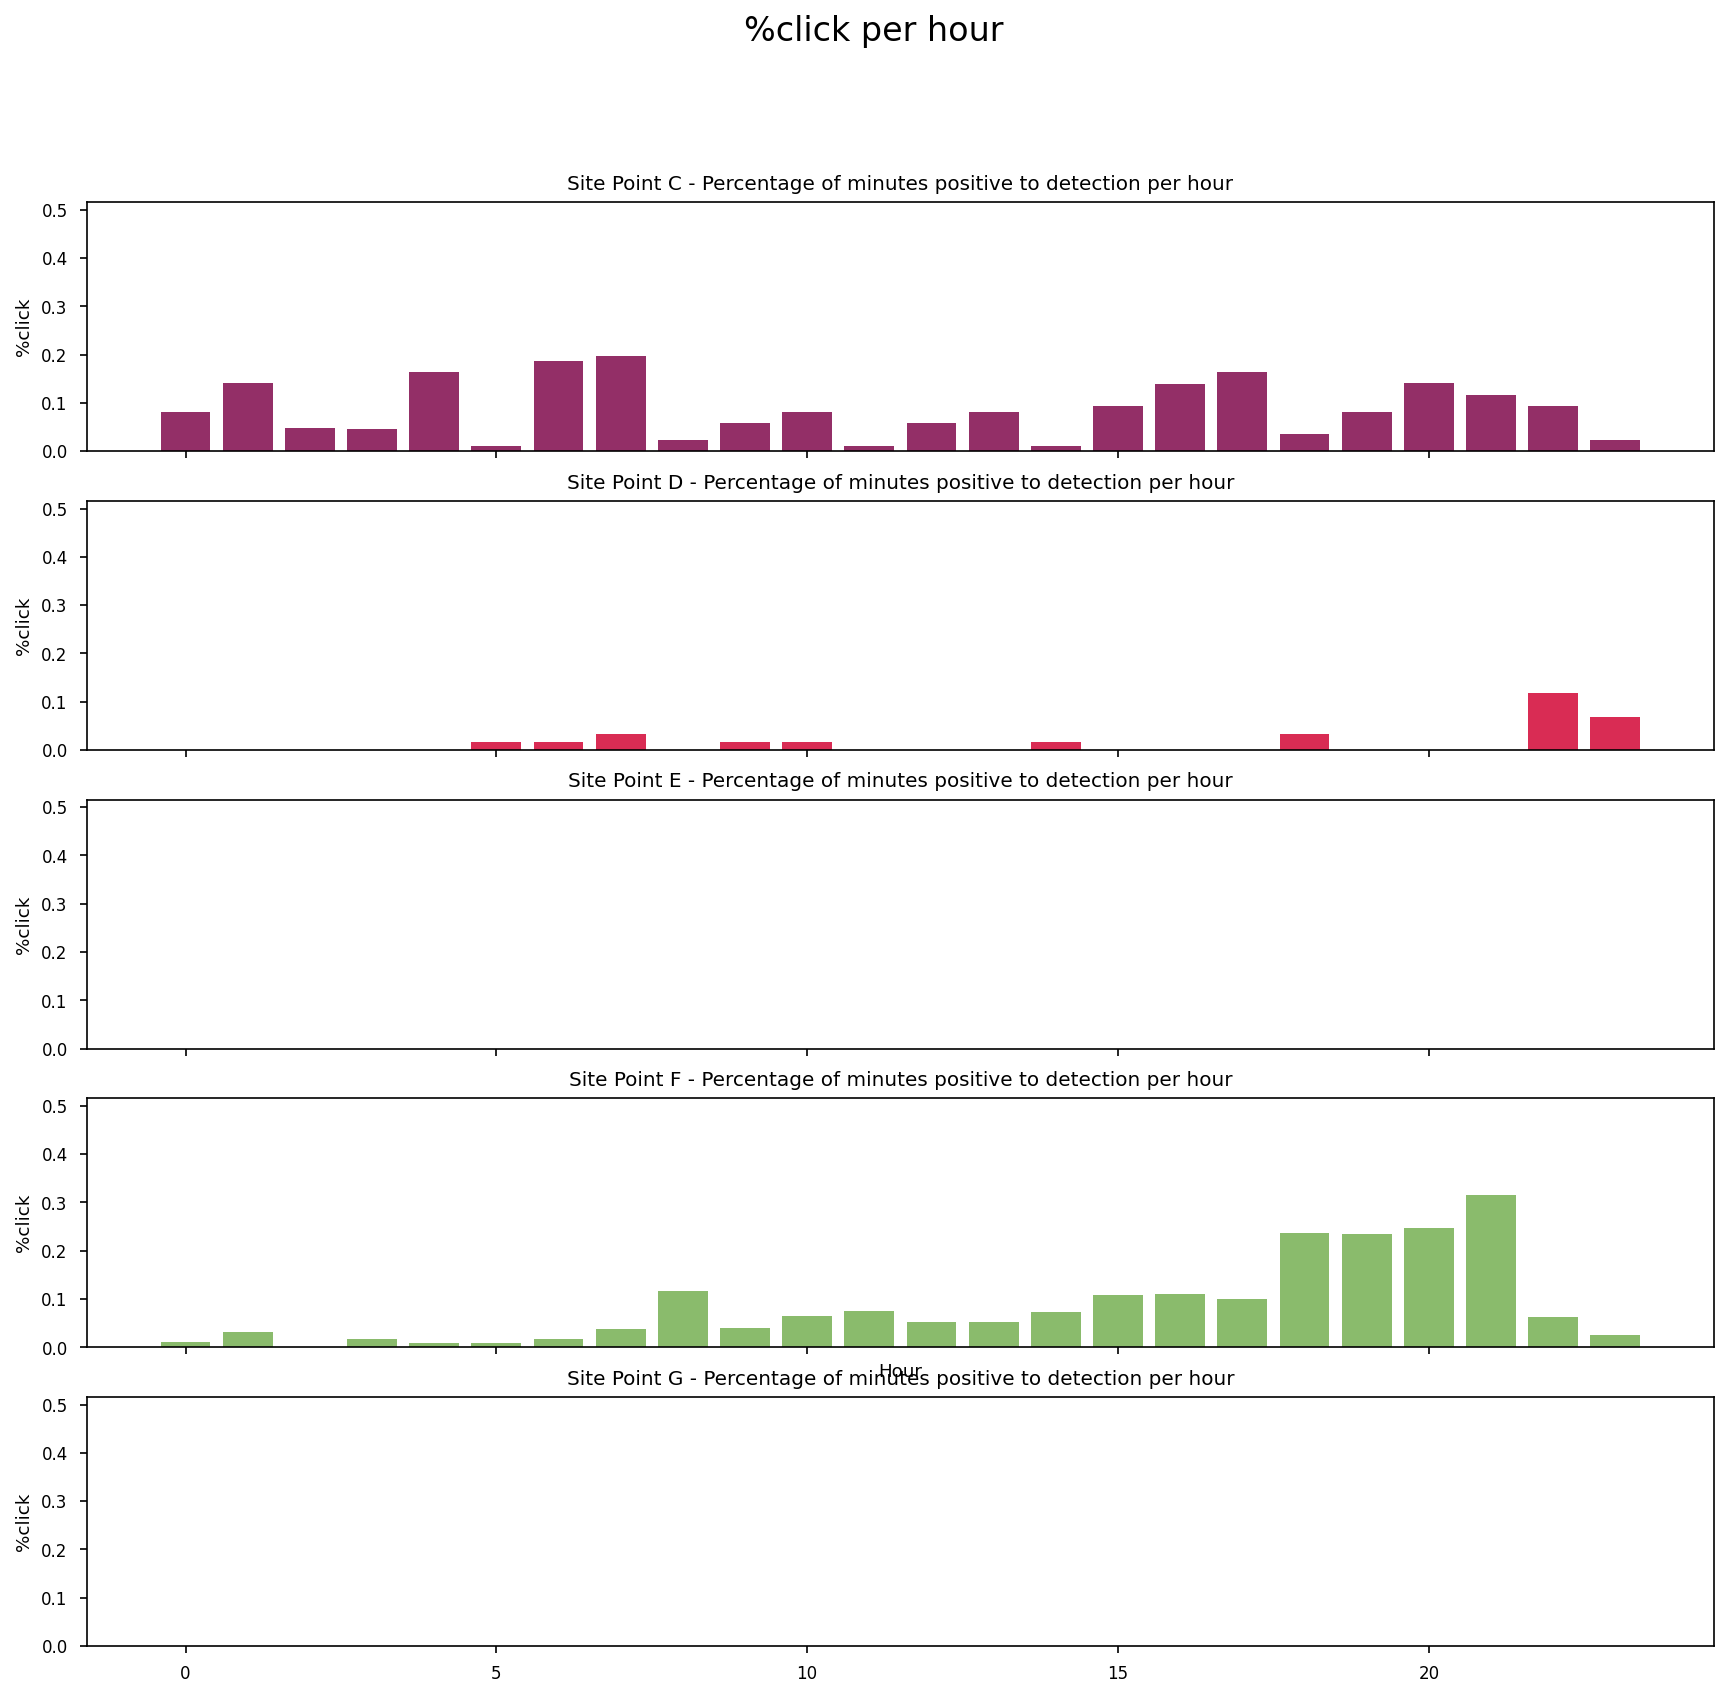

In [8]:
hour_percent(h_per, "%click")